In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Load datasets
math_df = pd.read_csv('student-mat.csv', sep=';')
por_df = pd.read_csv('student-por.csv', sep=';')

print('Mathematics dataset shape:', math_df.shape)
print('Portuguese dataset shape:', por_df.shape)

print('\nMathematics dataset preview:')
display(math_df.head())

print('\nPortuguese dataset preview:')
display(por_df.head())


Mathematics dataset shape: (395, 33)
Portuguese dataset shape: (649, 33)

Mathematics dataset preview:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10



Portuguese dataset preview:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [2]:
# 1. Check for missing values and duplicates in both datasets
print('=== Mathematics Dataset ===')
print('\nMissing values:')
print(math_df.isnull().sum())
print('\nDuplicate rows:', math_df.duplicated().sum())

print('\n=== Portuguese Dataset ===')
print('\nMissing values:')
print(por_df.isnull().sum())
print('\nDuplicate rows:', por_df.duplicated().sum())

# 2. Handle missing values and duplicates
math_cleaned = math_df.dropna()
por_cleaned = por_df.dropna()

math_cleaned = math_cleaned.drop_duplicates()
por_cleaned = por_cleaned.drop_duplicates()

print('\nAfter cleaning:')
print('Mathematics rows before:', len(math_df), 'after:', len(math_cleaned))
print('Portuguese rows before:', len(por_df), 'after:', len(por_cleaned))

# 3. Save individual cleaned datasets
math_cleaned.to_csv('student-mat-cleaned.csv', index=False)
por_cleaned.to_csv('student-por-cleaned.csv', index=False)

# 4. Preprocess and merge datasets
def preprocess_data(df, subject):
    """Preprocess the dataset with proper encoding and feature engineering."""
    df = df.copy()
    
    # Add subject identifier
    df['subject'] = subject
    
    # Encode categorical variables
    categorical_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 
                       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
                       'nursery', 'higher', 'internet', 'romantic']
    
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    
    # Feature engineering
    df['total_study_time'] = df['studytime'] * df['traveltime']
    df['parent_education'] = (df['Medu'] + df['Fedu']) / 2
    df['alcohol_consumption'] = (df['Dalc'] + df['Walc']) / 2
    
    return df

# Process both cleaned datasets
math_processed = preprocess_data(math_cleaned, 'math')
por_processed = preprocess_data(por_cleaned, 'portuguese')

# Merge datasets
merged_df = pd.concat([math_processed, por_processed], axis=0)

# Final check for duplicates in merged dataset
merged_df = merged_df.drop_duplicates()

# Save final merged and cleaned dataset
merged_df.to_csv('student-merged-cleaned.csv', index=False)

print('\nFinal merged dataset shape:', merged_df.shape)
print('Features available:', ', '.join(merged_df.columns))


=== Mathematics Dataset ===

Missing values:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

Duplicate rows: 0

=== Portuguese Dataset ===

Missing values:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      

In [3]:
# Load the cleaned merged dataset
merged_df = pd.read_csv('student-merged-cleaned.csv')

print('Cleaned dataset shape:', merged_df.shape)
print('\nVerification - No missing values:', merged_df.isnull().sum().sum() == 0)
print('Verification - No duplicates:', merged_df.duplicated().sum() == 0)

# Display sample of cleaned data
print('\nSample of cleaned data:')
display(merged_df.head())


Cleaned dataset shape: (1044, 37)

Verification - No missing values: True
Verification - No duplicates: True

Sample of cleaned data:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Walc,health,absences,G1,G2,G3,subject,total_study_time,parent_education,alcohol_consumption
0,0,0,18,1,0,0,4,4,0,4,...,1,3,6,5,6,6,math,4,4.0,1.0
1,0,0,17,1,0,1,1,1,0,2,...,1,3,4,5,5,6,math,2,1.0,1.0
2,0,0,15,1,1,1,1,1,0,2,...,3,3,10,7,8,10,math,2,1.0,2.5
3,0,0,15,1,0,1,4,2,1,3,...,1,5,2,15,14,15,math,3,3.0,1.0
4,0,0,16,1,0,1,3,3,2,2,...,2,5,4,6,10,10,math,2,3.0,1.5


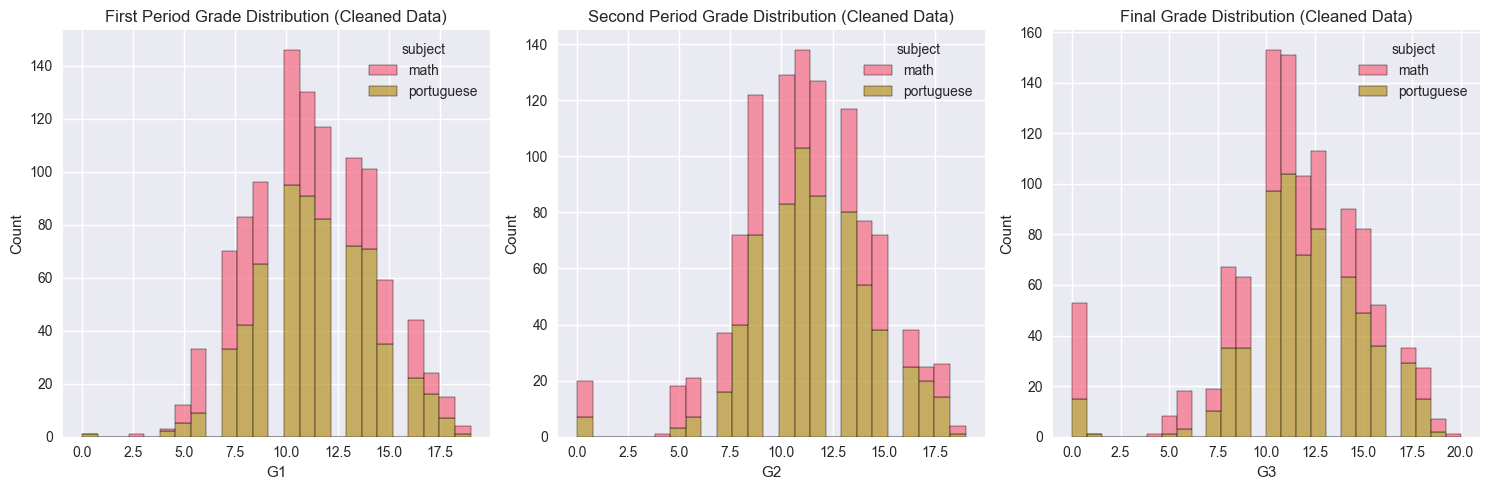

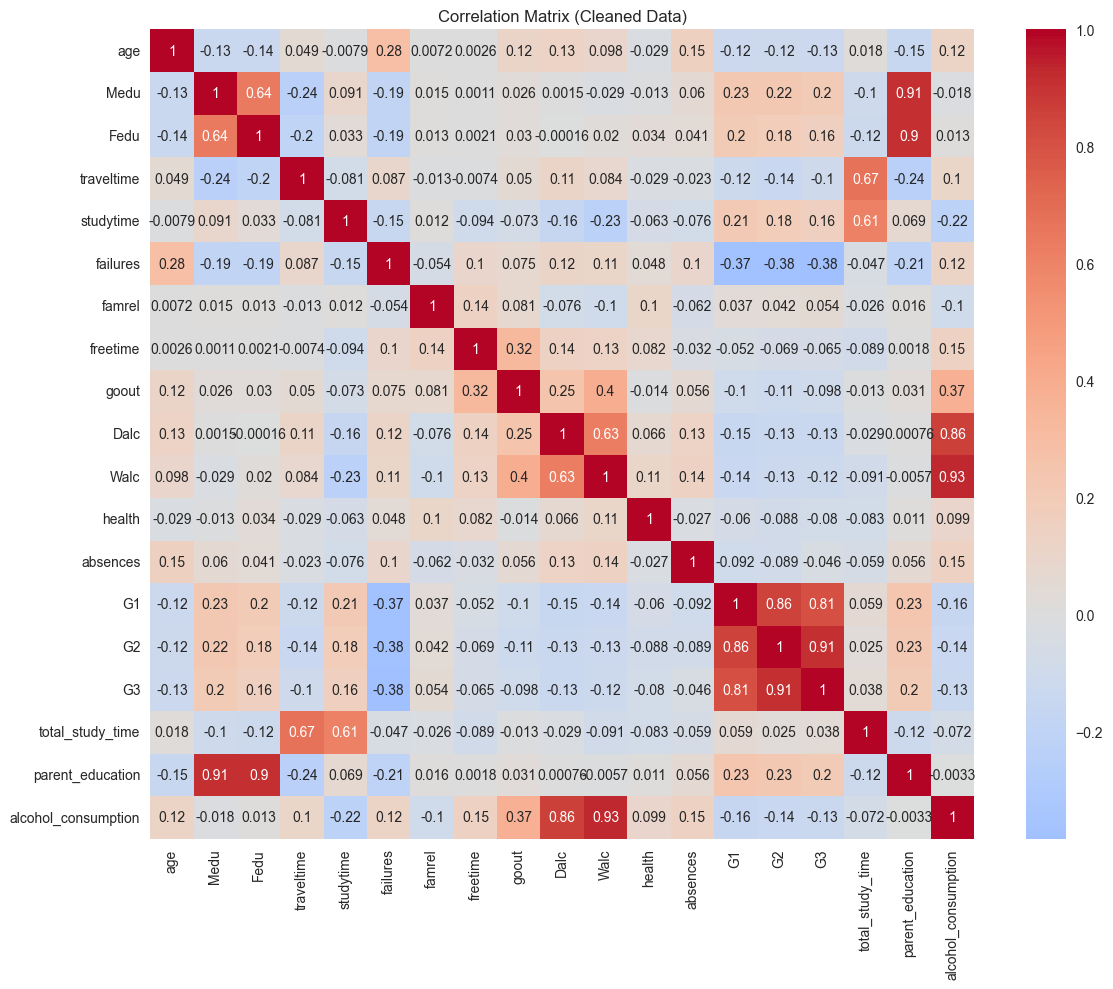

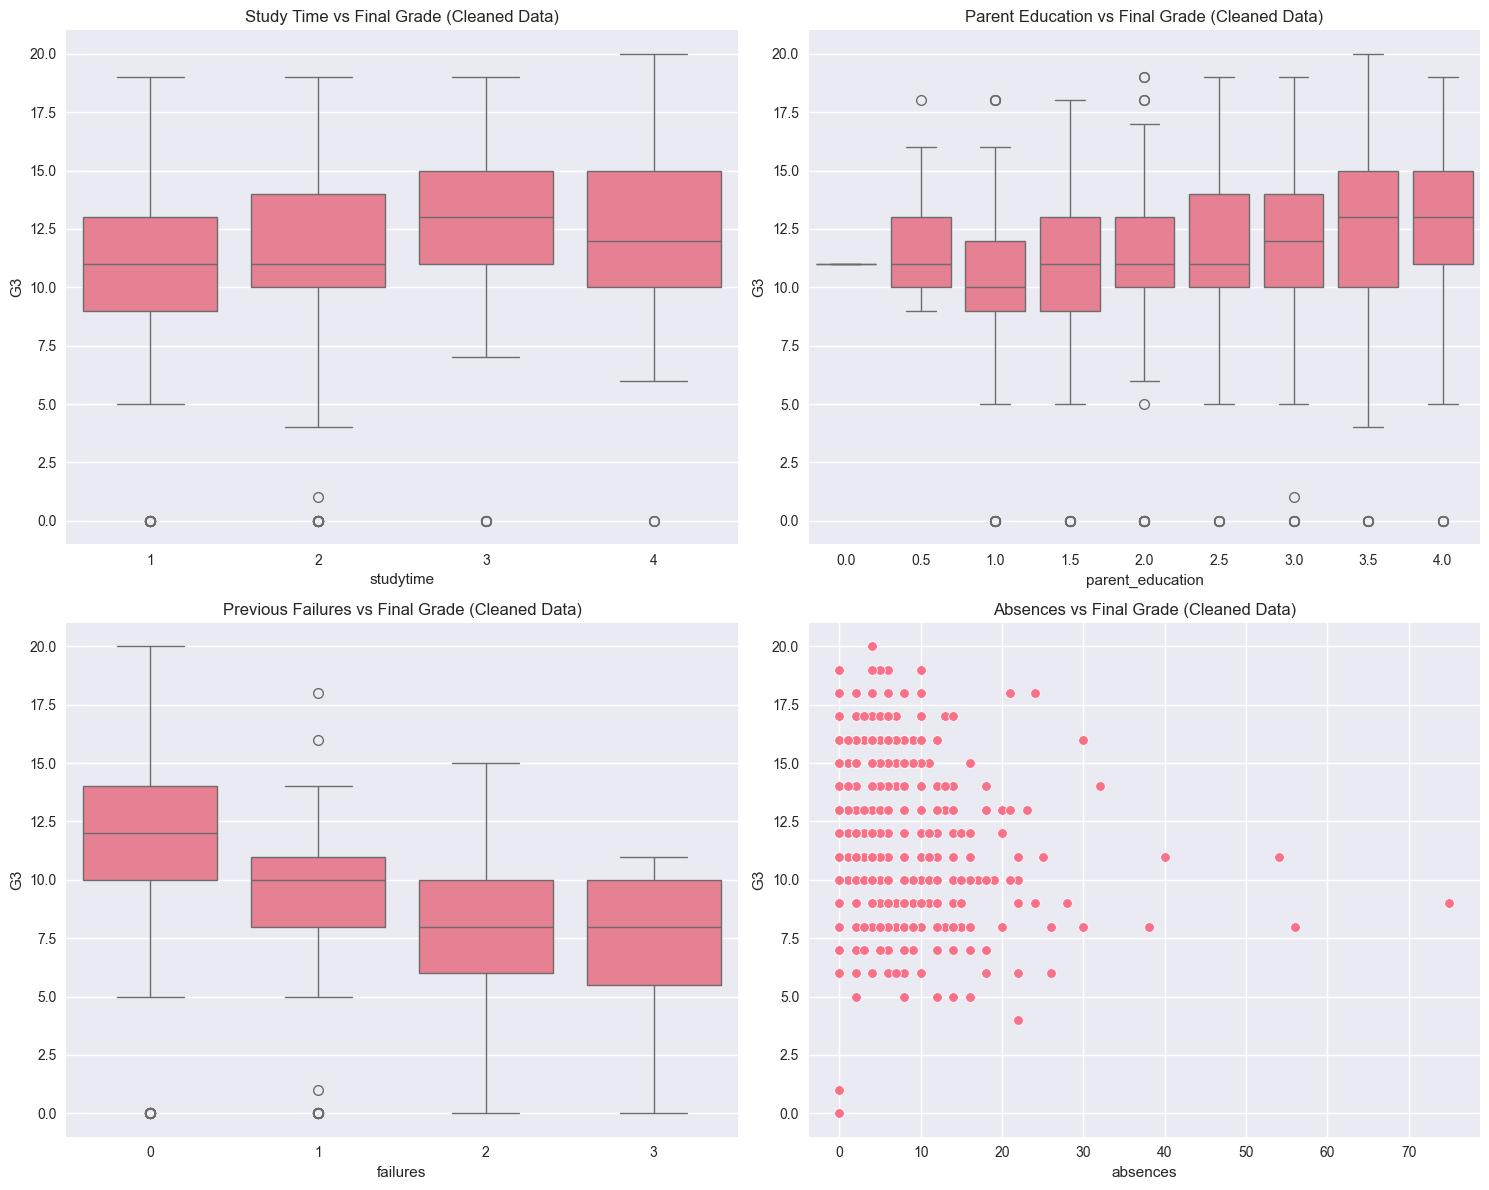

In [4]:
# Analysis using cleaned data
# 1. Grade Distributions
plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.histplot(data=merged_df, x='G1', hue='subject', multiple="stack")
plt.title('First Period Grade Distribution (Cleaned Data)')

plt.subplot(132)
sns.histplot(data=merged_df, x='G2', hue='subject', multiple="stack")
plt.title('Second Period Grade Distribution (Cleaned Data)')

plt.subplot(133)
sns.histplot(data=merged_df, x='G3', hue='subject', multiple="stack")
plt.title('Final Grade Distribution (Cleaned Data)')

plt.tight_layout()
plt.show()

# 2. Correlation Analysis using cleaned data
numeric_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
                'absences', 'G1', 'G2', 'G3', 'total_study_time',
                'parent_education', 'alcohol_consumption']

plt.figure(figsize=(12, 10))
sns.heatmap(merged_df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Cleaned Data)')
plt.tight_layout()
plt.show()

# 3. Key Factors Analysis using cleaned data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.boxplot(data=merged_df, x='studytime', y='G3', ax=axes[0,0])
axes[0,0].set_title('Study Time vs Final Grade (Cleaned Data)')

sns.boxplot(data=merged_df, x='parent_education', y='G3', ax=axes[0,1])
axes[0,1].set_title('Parent Education vs Final Grade (Cleaned Data)')

sns.boxplot(data=merged_df, x='failures', y='G3', ax=axes[1,0])
axes[1,0].set_title('Previous Failures vs Final Grade (Cleaned Data)')

sns.scatterplot(data=merged_df, x='absences', y='G3', ax=axes[1,1])
axes[1,1].set_title('Absences vs Final Grade (Cleaned Data)')

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Prepare features from cleaned data
def prepare_features(df):
    """Prepare features for modeling using cleaned data."""
    feature_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                    'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
                    'absences', 'G1', 'G2', 'total_study_time', 'parent_education',
                    'alcohol_consumption', 'school', 'sex', 'address', 'famsize',
                    'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities',
                    'nursery', 'higher', 'internet', 'romantic']
    
    X = df[feature_cols]
    y = df['G3']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled, y

# Prepare features and split cleaned data
X, y = prepare_features(merged_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training set shape (cleaned data):', X_train.shape)
print('Testing set shape (cleaned data):', X_test.shape)

# Train and evaluate models using cleaned data
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a model using cleaned data."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'\n{model_name} Results (Cleaned Data):')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R² Score: {r2:.4f}')
    
    return y_pred, model

# Random Forest on cleaned data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pred, rf_model = train_and_evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# XGBoost on cleaned data
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_pred, xgb_model = train_and_evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")

# Ensemble predictions on cleaned data
ensemble_pred = (rf_pred + xgb_pred) / 2
ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)

print('\nEnsemble Model Results (Cleaned Data):')
print(f'Mean Squared Error: {ensemble_mse:.4f}')
print(f'R² Score: {ensemble_r2:.4f}')

# Descriptive Statistics and Outlier Identification
# Select numerical columns for analysis
numerical_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                  'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
                  'absences', 'G1', 'G2', 'total_study_time', 'parent_education',
                  'alcohol_consumption', 'G3']

# Ensure only numerical columns present in merged_df are used
numerical_cols = [col for col in numerical_cols if col in merged_df.columns]

# 1. Descriptive Statistics
print("\nDescriptive Statistics for Numerical Features and Target (G3):")
desc_stats = merged_df[numerical_cols].describe()
print(desc_stats)

# Compute mode separately as describe() doesn't include it
modes = merged_df[numerical_cols].mode().iloc[0]
print("\nMode for Numerical Features and Target (G3):")
print(modes)

# 2. Data Ranges
ranges = merged_df[numerical_cols].max() - merged_df[numerical_cols].min()
print("\nData Ranges for Numerical Features and Target (G3):")
print(ranges)

# 3. Outlier Identification using IQR method
def detect_outliers(df, column):
    """Detect outliers in a column using the IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

# Identify outliers for each numerical column
print("\nOutliers for Numerical Features and Target (G3):")
for col in numerical_cols:
    outliers = detect_outliers(merged_df, col)
    if not outliers.empty:
        print(f"\n{col} Outliers (values outside 1.5*IQR):")
        print(outliers)
    else:
        print(f"\n{col}: No outliers detected")

Training set shape (cleaned data): (835, 31)
Testing set shape (cleaned data): (209, 31)

Random Forest Results (Cleaned Data):
Mean Squared Error: 2.9063
R² Score: 0.8120

XGBoost Results (Cleaned Data):
Mean Squared Error: 3.3923
R² Score: 0.7806

Ensemble Model Results (Cleaned Data):
Mean Squared Error: 3.0165
R² Score: 0.8049

Descriptive Statistics for Numerical Features and Target (G3):
               age         Medu         Fedu   traveltime    studytime  \
count  1044.000000  1044.000000  1044.000000  1044.000000  1044.000000   
mean     16.726054     2.603448     2.387931     1.522989     1.970307   
std       1.239975     1.124907     1.099938     0.731727     0.834353   
min      15.000000     0.000000     0.000000     1.000000     1.000000   
25%      16.000000     2.000000     1.000000     1.000000     1.000000   
50%      17.000000     3.000000     2.000000     1.000000     2.000000   
75%      18.000000     4.000000     3.000000     2.000000     2.000000   
max      22

Detailed risk report saved to detailed_risk_analysis.csv


C:\Users\THOTI\AppData\Local\Temp\ipykernel_6408\1356569619.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_means = risk_report.groupby('Risk_Category')[
C:\Users\THOTI\AppData\Local\Temp\ipykernel_6408\1356569619.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support_impact = risk_report.groupby('Risk_Category')[support_cols].mean()


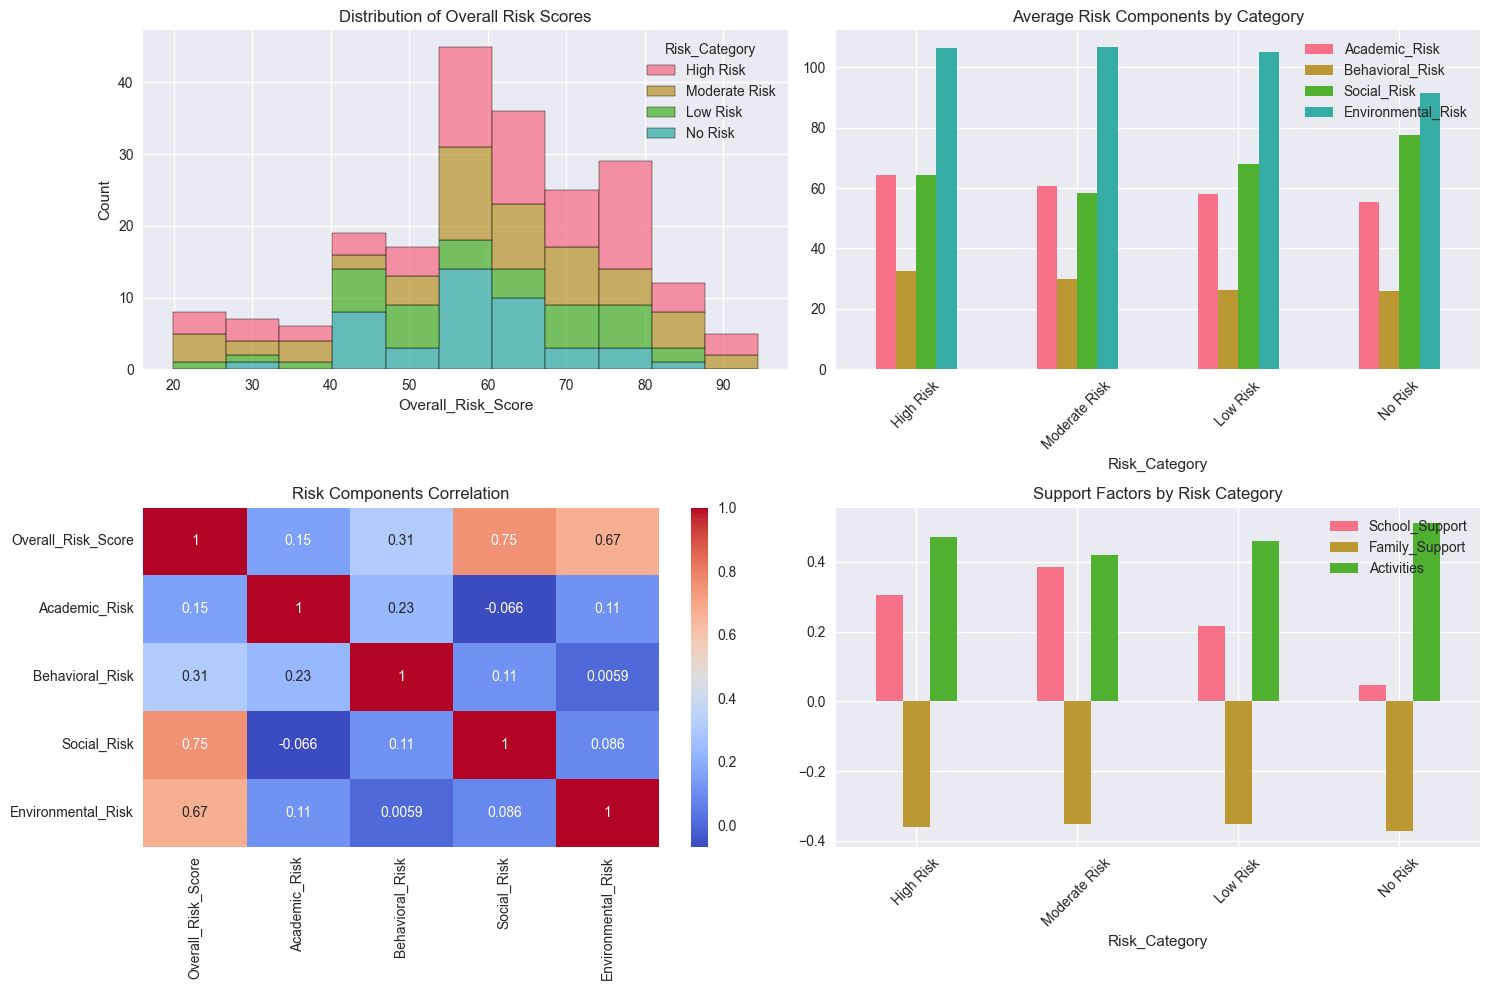


Risk Analysis Insights:
--------------------------------------------------
High Risk Students: 72
Average Risk Score: 60.78

Top Risk Factors (correlation with predicted grades):
Academic_Risk        -0.786287
Behavioral_Risk      -0.165772
Overall_Risk_Score   -0.131398
Environmental_Risk   -0.118259
Social_Risk           0.055651
Name: Predicted_Grade, dtype: float64


In [9]:
# Enhanced Risk Analysis

# 1. Calculate Component Risk Scores
def calculate_risk_components(data):
    """Calculate different components of risk score"""
    
    # Academic Risk (30% weight)
    academic_risk = (
        (20 - data['G1']) * 0.4 +  # Previous grade
        data['failures'] * 0.4 +    # Past failures
        (20 - data['G2']) * 0.2    # Current grade
    ) / 20 * 100
    
    # Behavioral Risk (30% weight)
    behavioral_risk = (
        (data['absences'] / 10) * 0.4 +          # Attendance
        ((4 - data['studytime']) / 4) * 0.3 +    # Study time
        (data['goout'] / 5) * 0.3                # Going out frequency
    ) * 100
    
    # Social Risk (20% weight)
    social_risk = (
        (1 - data['schoolsup']) * 0.4 +     # School support
        (1 - data['famsup']) * 0.3 +        # Family support
        (data['alcohol_consumption'] / 5) * 0.3  # Alcohol consumption
    ) * 100
    
    # Environmental Risk (20% weight)
    environmental_risk = (
        (1 - data['internet']) * 0.3 +      # Internet access
        (5 - data['famrel']) / 5 * 0.4 +    # Family relationship
        (1 - data['activities']) * 0.3      # Extra activities
    ) * 100
    
    return pd.DataFrame({
        'Academic_Risk': academic_risk,
        'Behavioral_Risk': behavioral_risk,
        'Social_Risk': social_risk,
        'Environmental_Risk': environmental_risk
    })

# Calculate risk components
risk_components = calculate_risk_components(X_test)

# 2. Calculate Overall Risk Score
risk_components['Overall_Risk'] = (
    risk_components['Academic_Risk'] * 0.3 +
    risk_components['Behavioral_Risk'] * 0.3 +
    risk_components['Social_Risk'] * 0.2 +
    risk_components['Environmental_Risk'] * 0.2
)

# 3. Create Enhanced Risk Categories
risk_categories = pd.cut(ensemble_pred,
                        bins=[-np.inf, 10, 12, 14, np.inf],
                        labels=['High Risk', 'Moderate Risk', 'Low Risk', 'No Risk'])

# 4. Create Comprehensive Risk Report
risk_report = pd.DataFrame({
    'Predicted_Grade': ensemble_pred,
    'Risk_Category': risk_categories,
    'Overall_Risk_Score': risk_components['Overall_Risk'],
    'Academic_Risk': risk_components['Academic_Risk'],
    'Behavioral_Risk': risk_components['Behavioral_Risk'],
    'Social_Risk': risk_components['Social_Risk'],
    'Environmental_Risk': risk_components['Environmental_Risk'],
    'Study_Time': X_test['studytime'],
    'Failures': X_test['failures'],
    'Absences': X_test['absences'],
    'School_Support': X_test['schoolsup'],
    'Family_Support': X_test['famsup'],
    'Activities': X_test['activities']
})

# Save detailed risk report
risk_report.to_csv('detailed_risk_analysis.csv', index=False)
print('Detailed risk report saved to detailed_risk_analysis.csv')

# 5. Visualize Risk Components
plt.figure(figsize=(15, 10))

# Risk Distribution
plt.subplot(2, 2, 1)
sns.histplot(data=risk_report, x='Overall_Risk_Score', hue='Risk_Category', multiple="stack")
plt.title('Distribution of Overall Risk Scores')

# Risk Components by Category
plt.subplot(2, 2, 2)
risk_means = risk_report.groupby('Risk_Category')[
    ['Academic_Risk', 'Behavioral_Risk', 'Social_Risk', 'Environmental_Risk']
].mean()
risk_means.plot(kind='bar', ax=plt.gca())
plt.title('Average Risk Components by Category')
plt.xticks(rotation=45)

# Risk Correlation Matrix
plt.subplot(2, 2, 3)
risk_cols = ['Overall_Risk_Score', 'Academic_Risk', 'Behavioral_Risk', 
             'Social_Risk', 'Environmental_Risk']
sns.heatmap(risk_report[risk_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Risk Components Correlation')

# Support vs Risk
plt.subplot(2, 2, 4)
support_cols = ['School_Support', 'Family_Support', 'Activities']
risk_report[support_cols] = risk_report[support_cols].astype(int)
support_impact = risk_report.groupby('Risk_Category')[support_cols].mean()
support_impact.plot(kind='bar', ax=plt.gca())
plt.title('Support Factors by Risk Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 6. Generate Risk Insights
print('\nRisk Analysis Insights:')
print('-' * 50)
print(f'High Risk Students: {len(risk_report[risk_report["Risk_Category"] == "High Risk"])}')
print(f'Average Risk Score: {risk_report["Overall_Risk_Score"].mean():.2f}')

# Risk factors correlation with predicted grades
correlations = risk_report[risk_cols + ['Predicted_Grade']].corr()['Predicted_Grade'].sort_values()
print('\nTop Risk Factors (correlation with predicted grades):')
print(correlations[:-1])


In [10]:
# Generate Intervention Recommendations
def generate_recommendations(risk_data):
    """Generate specific recommendations based on risk components."""
    recommendations = []
    
    # Academic Interventions
    if risk_data['Academic_Risk'] > 70:
        recommendations.append({
            'Category': 'Academic',
            'Priority': 'High',
            'Interventions': [
                'Immediate tutoring in weak subjects',
                'Weekly progress monitoring',
                'Study skills workshop'
            ]
        })
    
    # Behavioral Interventions
    if risk_data['Behavioral_Risk'] > 60:
        recommendations.append({
            'Category': 'Behavioral',
            'Priority': 'Medium',
            'Interventions': [
                'Attendance monitoring',
                'Study schedule planning',
                'Time management workshop'
            ]
        })
    
    # Social Support
    if risk_data['Social_Risk'] > 50:
        recommendations.append({
            'Category': 'Social',
            'Priority': 'Medium',
            'Interventions': [
                'Parent-teacher meeting',
                'Social support group',
                'Counseling services'
            ]
        })
    
    # Environmental Support
    if risk_data['Environmental_Risk'] > 50:
        recommendations.append({
            'Category': 'Environmental',
            'Priority': 'Low',
            'Interventions': [
                'Study environment assessment',
                'Access to school resources',
                'After-school study program'
            ]
        })
    
    return recommendations

# Generate recommendations for high-risk students
high_risk_students = risk_report[risk_report['Risk_Category'] == 'High Risk']
sample_student = high_risk_students.iloc[0]

print("Sample Intervention Plan for High-Risk Student")
print("-" * 50)
print(f"Risk Scores:")
print(f"Academic Risk: {sample_student['Academic_Risk']:.2f}")
print(f"Behavioral Risk: {sample_student['Behavioral_Risk']:.2f}")
print(f"Social Risk: {sample_student['Social_Risk']:.2f}")
print(f"Environmental Risk: {sample_student['Environmental_Risk']:.2f}")
print(f"Overall Risk: {sample_student['Overall_Risk_Score']:.2f}")

print("\nRecommended Interventions:")
recommendations = generate_recommendations(sample_student)
for rec in recommendations:
    print(f"\n{rec['Category']} Interventions (Priority: {rec['Priority']})")
    for intervention in rec['Interventions']:
        print(f"- {intervention}")

# Save recommendations for Power BI
recommendations_df = pd.DataFrame(recommendations)
recommendations_df.to_csv('intervention_recommendations.csv', index=False)
print("\nRecommendations saved to intervention_recommendations.csv")


Sample Intervention Plan for High-Risk Student
--------------------------------------------------
Risk Scores:
Academic Risk: 62.34
Behavioral Risk: 59.60
Social Risk: 128.81
Environmental Risk: 53.74
Overall Risk: 73.09

Recommended Interventions:

Social Interventions (Priority: Medium)
- Parent-teacher meeting
- Social support group
- Counseling services

Environmental Interventions (Priority: Low)
- Study environment assessment
- Access to school resources
- After-school study program

Recommendations saved to intervention_recommendations.csv


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Assuming merged_df is already defined (replace with actual loading if needed)
# merged_df = pd.read_csv('student-merged-cleaned.csv')

# Prepare features from cleaned data
def prepare_features(df):
    """Prepare features for modeling using cleaned data."""
    feature_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                    'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
                    'absences', 'G1', 'G2', 'total_study_time', 'parent_education',
                    'alcohol_consumption', 'school', 'sex', 'address', 'famsize',
                    'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities',
                    'nursery', 'higher', 'internet', 'romantic']
    
    # Filter columns that exist in df
    feature_cols = [col for col in feature_cols if col in df.columns]
    X = df[feature_cols]
    y = df['G3']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled, y

# Prepare features and split cleaned data
X, y = prepare_features(merged_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training set shape (cleaned data):', X_train.shape)
print('Testing set shape (cleaned data):', X_test.shape)

# Train and evaluate models using cleaned data
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a model using cleaned data."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'\n{model_name} Results (Cleaned Data):')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R² Score: {r2:.4f}')
    
    return y_pred, model

# Random Forest on cleaned data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pred, rf_model = train_and_evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# XGBoost on cleaned data
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_pred, xgb_model = train_and_evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")

# Ensemble predictions on cleaned data
ensemble_pred = (rf_pred + xgb_pred) / 2
ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)

print('\nEnsemble Model Results (Cleaned Data):')
print(f'Mean Squared Error: {ensemble_mse:.4f}')
print(f'R² Score: {ensemble_r2:.4f}')

# Prepare comprehensive dataset for Power BI
powerbi_export = merged_df.copy()

# Define risk categories based on predicted grades
def assign_risk_categories(predictions):
    """Assign risk categories based on predicted grades."""
    return pd.cut(predictions, 
                  bins=[-float('inf'), 10, 14, float('inf')], 
                  labels=['High Risk', 'Medium Risk', 'Low Risk'],
                  include_lowest=True)

# Generate risk categories for the test set predictions
risk_categories = assign_risk_categories(ensemble_pred)

# Ensure we only use valid indices from the test set
valid_test_idx = X_test.index.intersection(merged_df.index)

# Add model predictions and risk categories
powerbi_export.loc[valid_test_idx, 'Predicted_Grade'] = ensemble_pred[X_test.index.get_indexer(valid_test_idx)]
powerbi_export.loc[valid_test_idx, 'Risk_Category'] = risk_categories[X_test.index.get_indexer(valid_test_idx)]

# Add performance indicators
powerbi_export['Grade_Improvement'] = powerbi_export['G3'] - powerbi_export['G1']
powerbi_export['Is_Improving'] = powerbi_export['Grade_Improvement'] > 0
powerbi_export['Performance_Level'] = pd.qcut(powerbi_export['G3'], q=4, 
                                            labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Add additional metrics for analysis
# Avoid division by zero in Study_Efficiency
powerbi_export['Study_Efficiency'] = np.where(powerbi_export['total_study_time'] != 0,
                                             powerbi_export['G3'] / powerbi_export['total_study_time'],
                                             0)
powerbi_export['Risk_Score'] = (powerbi_export['failures'] * 0.3 +
                                (20 - powerbi_export['total_study_time']) * 0.3 +
                                powerbi_export['absences'] * 0.2 +
                                powerbi_export['alcohol_consumption'] * 0.2)

# Save final dataset for Power BI
powerbi_export.to_csv('powerbi_export.csv', index=False)
print(f'Data exported successfully with {len(powerbi_export)} total rows')
print(f'Number of rows with predictions: {len(valid_test_idx)}')

# Display sample of exported data
# Check if 'subject' column exists; if not, exclude it
display_cols = ['G3', 'Predicted_Grade', 'Risk_Category', 
                'Grade_Improvement', 'Is_Improving', 'Performance_Level',
                'Study_Efficiency', 'Risk_Score']
if 'subject' in powerbi_export.columns:
    display_cols.insert(0, 'subject')

print('\nSample of exported data:')
display(powerbi_export[display_cols].head())

# Verify data quality
print('\nData Quality Verification:')
print('Rows with predictions:', powerbi_export['Predicted_Grade'].notna().sum())
print('Rows with risk categories:', powerbi_export['Risk_Category'].notna().sum())
print('No missing values in key metrics:', 
      powerbi_export[['Study_Efficiency', 'Risk_Score', 'Grade_Improvement']].isnull().sum().sum() == 0)

Training set shape (cleaned data): (835, 31)
Testing set shape (cleaned data): (209, 31)

Random Forest Results (Cleaned Data):
Mean Squared Error: 2.9063
R² Score: 0.8120

XGBoost Results (Cleaned Data):
Mean Squared Error: 3.3923
R² Score: 0.7806

Ensemble Model Results (Cleaned Data):
Mean Squared Error: 3.0165
R² Score: 0.8049
Data exported successfully with 1044 total rows
Number of rows with predictions: 209

Sample of exported data:


,subject,G3,Predicted_Grade,Risk_Category,Grade_Improvement,Is_Improving,Performance_Level,Study_Efficiency,Risk_Score
0,math,6,NaN,NaN,1,True,Low,1.5,6.2
1,math,6,NaN,NaN,1,True,Low,3.0,6.4
2,math,10,7.126730,High Risk,3,True,Low,5.0,8.8
3,math,15,14.394291,Low Risk,0,False,High,5.0,5.7
4,math,10,NaN,NaN,4,True,Low,5.0,6.5



Data Quality Verification:
Rows with predictions: 209
Rows with risk categories: 209
No missing values in key metrics: True


In [15]:
# Final verification of all outputs
print("Final Project Verification")
print("-" * 50)

# 1. Check all exported files
import os

files_to_check = [
    'student-mat-cleaned.csv',
    'student-por-cleaned.csv',
    'student-merged-cleaned.csv',
    'detailed_risk_analysis.csv',
    'intervention_recommendations.csv',
    'powerbi_export.csv'
]

print("\nVerifying exported files:")
for file in files_to_check:
    exists = os.path.exists(file)
    print(f"{file}: {'✓ Present' if exists else '✗ Missing'}")

# 2. Data quality summary
print("\nData Quality Summary:")
print(f"Total students analyzed: {len(merged_df)}")
print(f"Features used: {len(X.columns)}")
print(f"Missing values: {merged_df.isnull().sum().sum()}")
print(f"Duplicate rows: {merged_df.duplicated().sum()}")

# 3. Model performance summary
print("\nModel Performance Summary:")
print(f"Random Forest R² Score: {rf_r2:.4f}")
print(f"XGBoost R² Score: {xgb_r2:.4f}")
print(f"Ensemble R² Score: {ensemble_r2:.4f}")

# 4. Risk analysis summary
print("\nRisk Analysis Summary:")
risk_distribution = risk_report['Risk_Category'].value_counts()
for category, count in risk_distribution.items():
    percentage = (count / len(risk_report)) * 100
    print(f"{category}: {count} students ({percentage:.1f}%)")


Final Project Verification
--------------------------------------------------

Verifying exported files:
student-mat-cleaned.csv: ✓ Present
student-por-cleaned.csv: ✓ Present
student-merged-cleaned.csv: ✓ Present
detailed_risk_analysis.csv: ✓ Present
intervention_recommendations.csv: ✓ Present
powerbi_export.csv: ✓ Present

Data Quality Summary:
Total students analyzed: 1044
Features used: 31
Missing values: 0
Duplicate rows: 0

Model Performance Summary:
Random Forest R² Score: 0.8120
XGBoost R² Score: 0.7806
Ensemble R² Score: 0.8049

Risk Analysis Summary:
Medium Risk: 94 students (45.0%)
High Risk: 72 students (34.4%)
Low Risk: 43 students (20.6%)
